In [16]:
import SimpleITK as sitk
import ipyvolume as ipv
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.ndimage import zoom
import gui
%matplotlib notebook

In [10]:
def plot_img(img, s=400):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(sitk.GetArrayViewFromImage(img)[s,:,:], cmap=plt.cm.Greys_r)
    plt.axis('off')

In [4]:
def load_dataset(path):
    series_reader = sitk.ImageSeriesReader()
    cur_paths = series_reader.GetGDCMSeriesFileNames(path)
    img = sitk.ReadImage(cur_paths)
    return img

I'll do 205 and 122 right lung and 

In [5]:
rlung205 = load_dataset("/home/share/rochester_CT/Lungmap_D205_anonymized_RightLung/Right Lung/AX BONE .67 - 3")

In [6]:
rlung122 = load_dataset("/home/share/rochester_CT/Lungmap_D122_anonymized_RightLung/Localizers/AX 1024 - 3/")

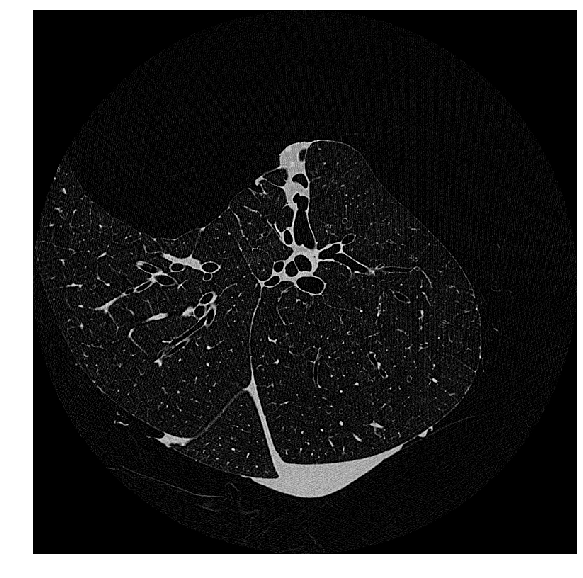

In [11]:
plot_img(rlung205)

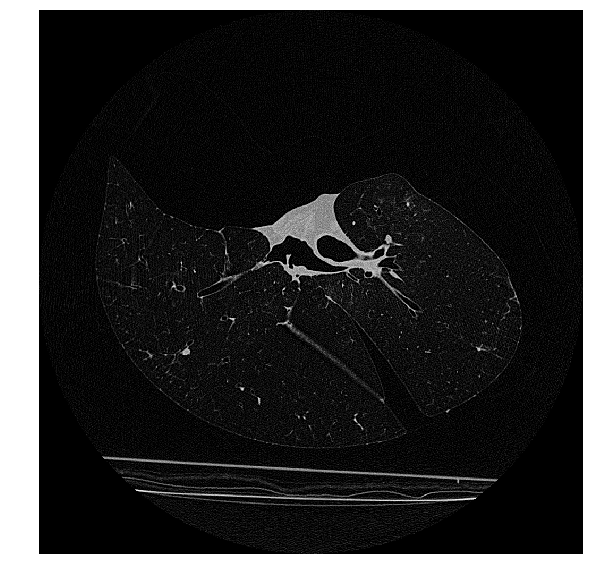

In [12]:
plot_img(rlung122)

## Smoothing

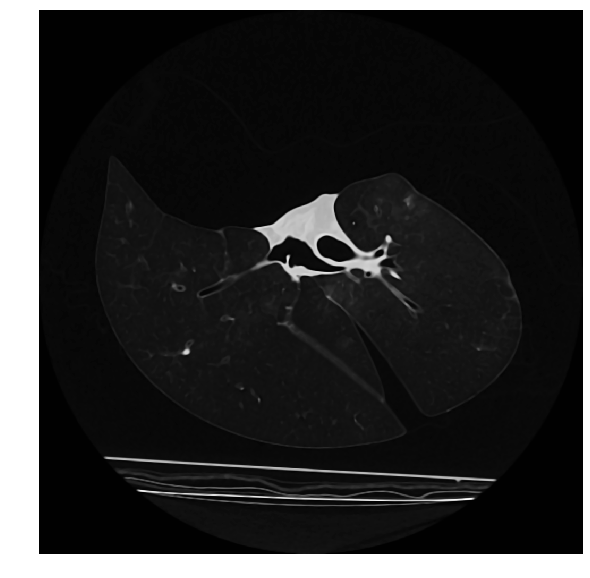

In [13]:
imdenoise122 = sitk.CurvatureFlow(
    image1=rlung122,
    timeStep=0.01,
    numberOfIterations=30
)

rlung122_smooth = imdenoise122
plot_img(rlung122_smooth, 400)

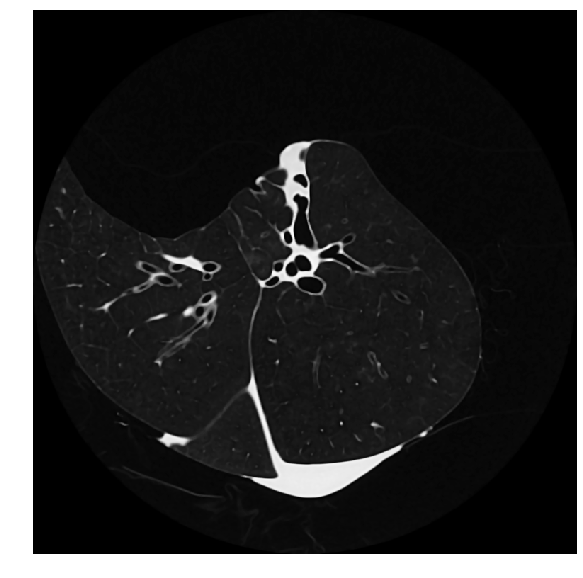

In [14]:
imdenoise205 = sitk.CurvatureFlow(
    image1=rlung205,
    timeStep=0.01,
    numberOfIterations=30
)

rlung205_smooth = imdenoise205
plot_img(rlung205_smooth, 400)

## Segmentation

<IPython.core.display.Javascript object>


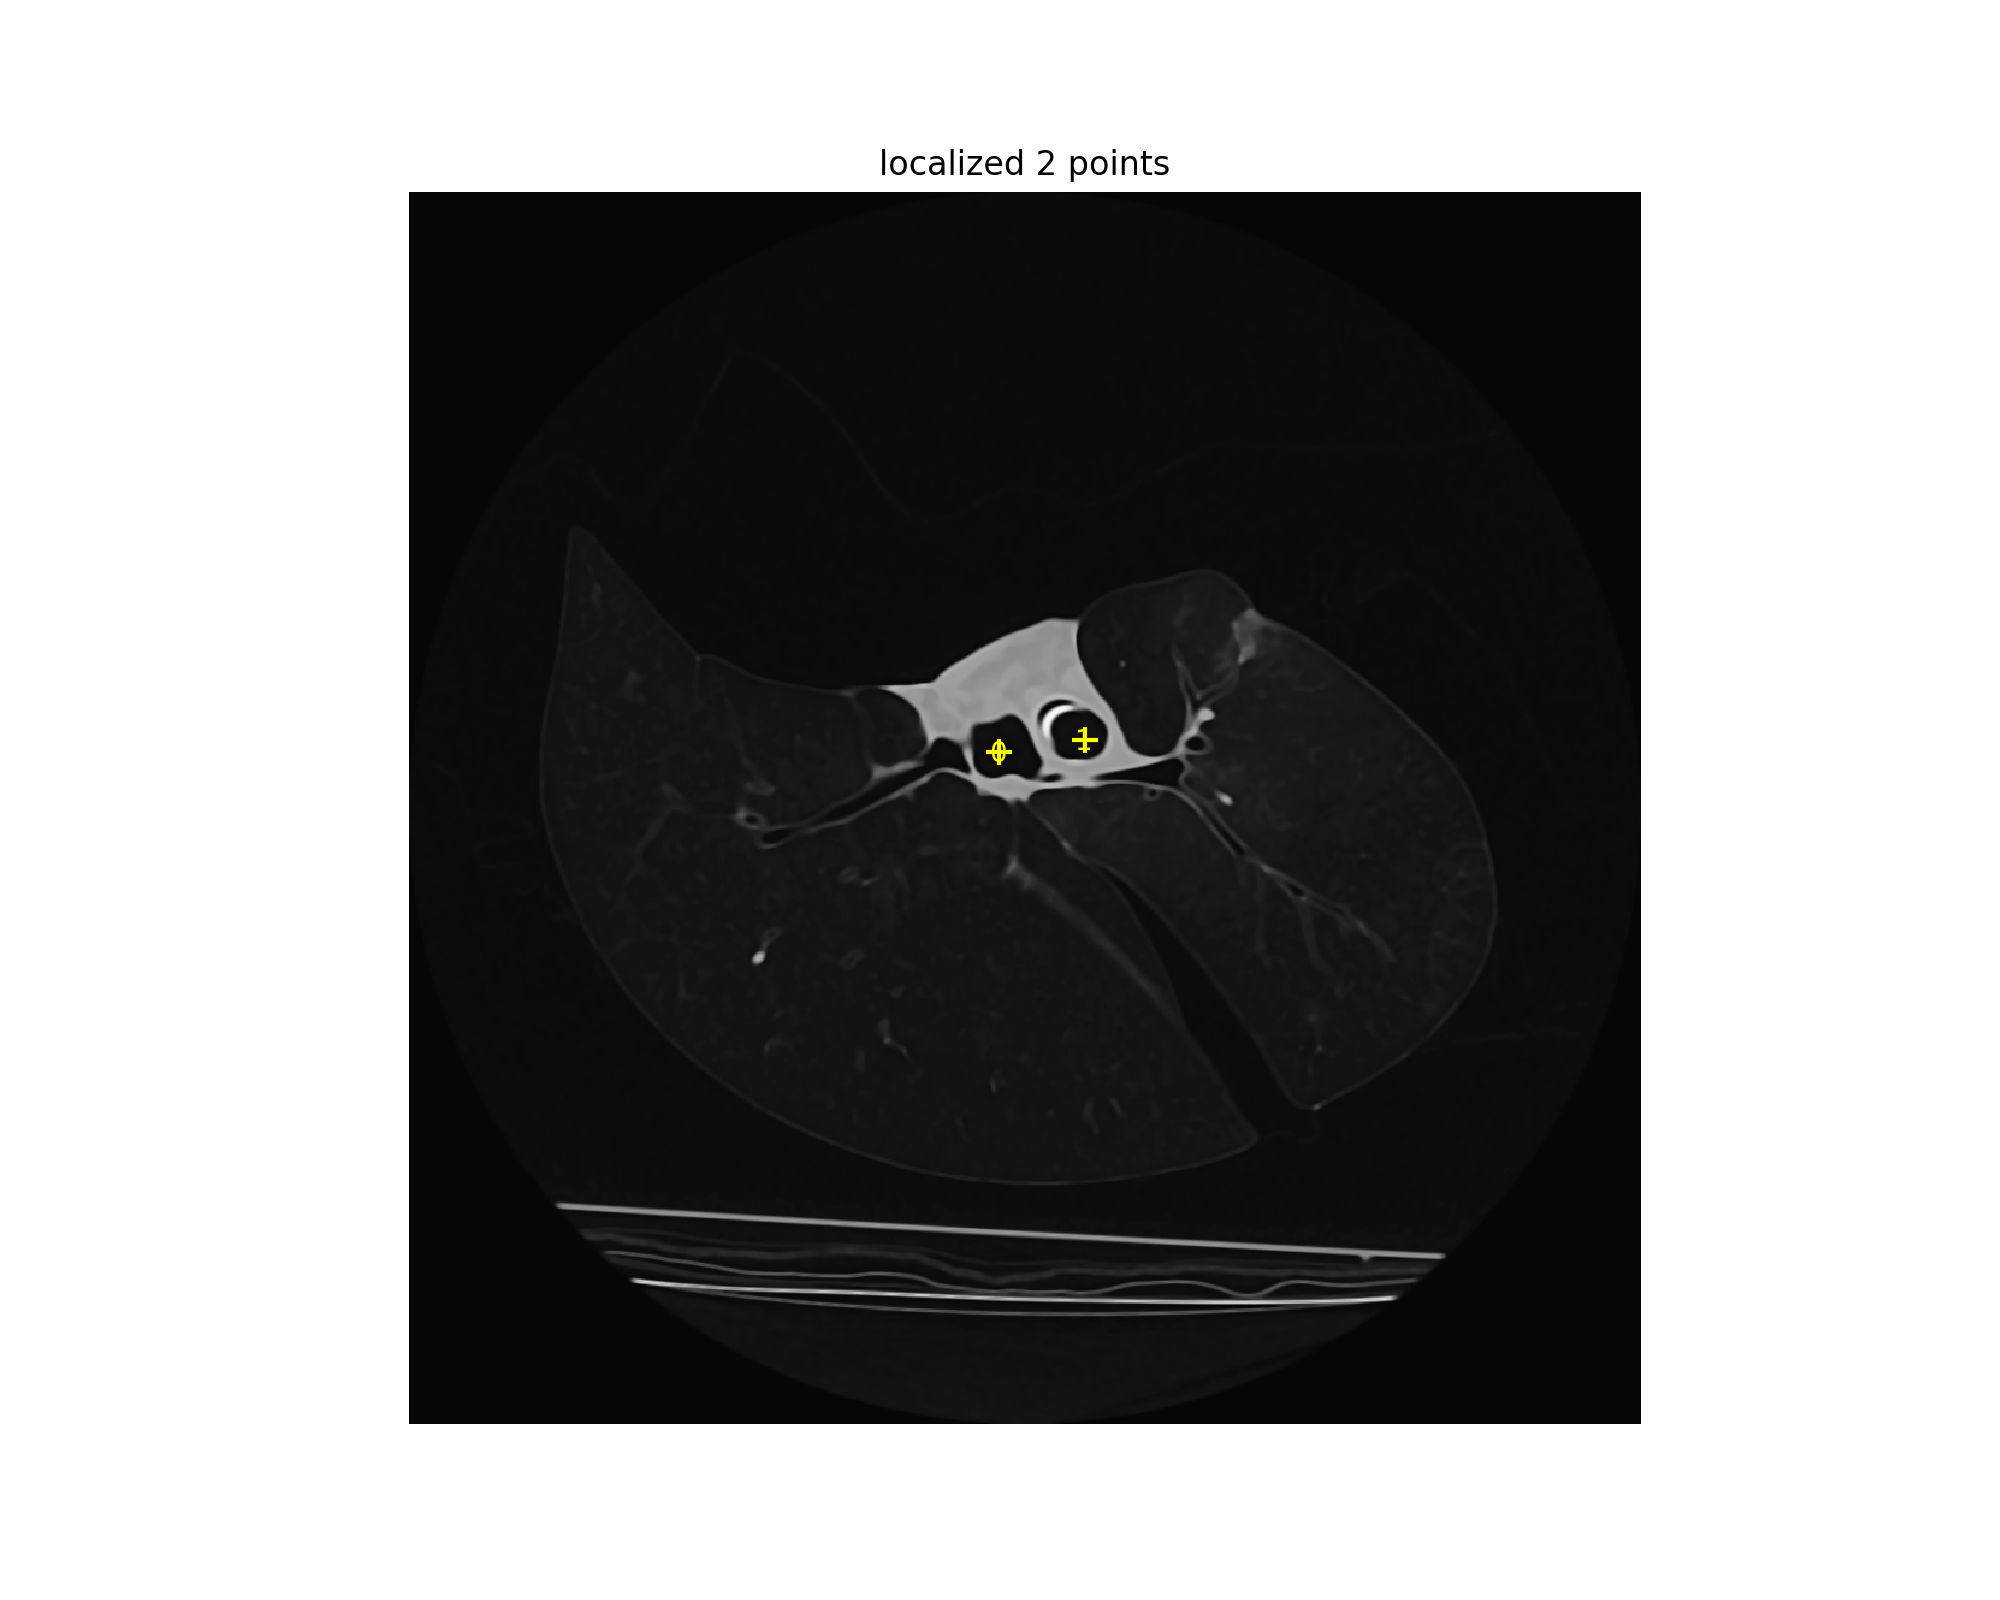

In [24]:
point_acquisition_interface = gui.PointDataAquisition(rlung122_smooth)

In [25]:
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()

In [26]:
initial_seed_point_indexes

[(490, 465, 411), (562, 455, 411)]

In [37]:
seg_122 = sitk.ConfidenceConnected(
    rlung122_smooth,
    seedList=initial_seed_point_indexes,
    numberOfIterations=2,
    multiplier=3,
    initialNeighborhoodRadius=1,
    replaceValue=1
)

<IPython.core.display.Javascript object>


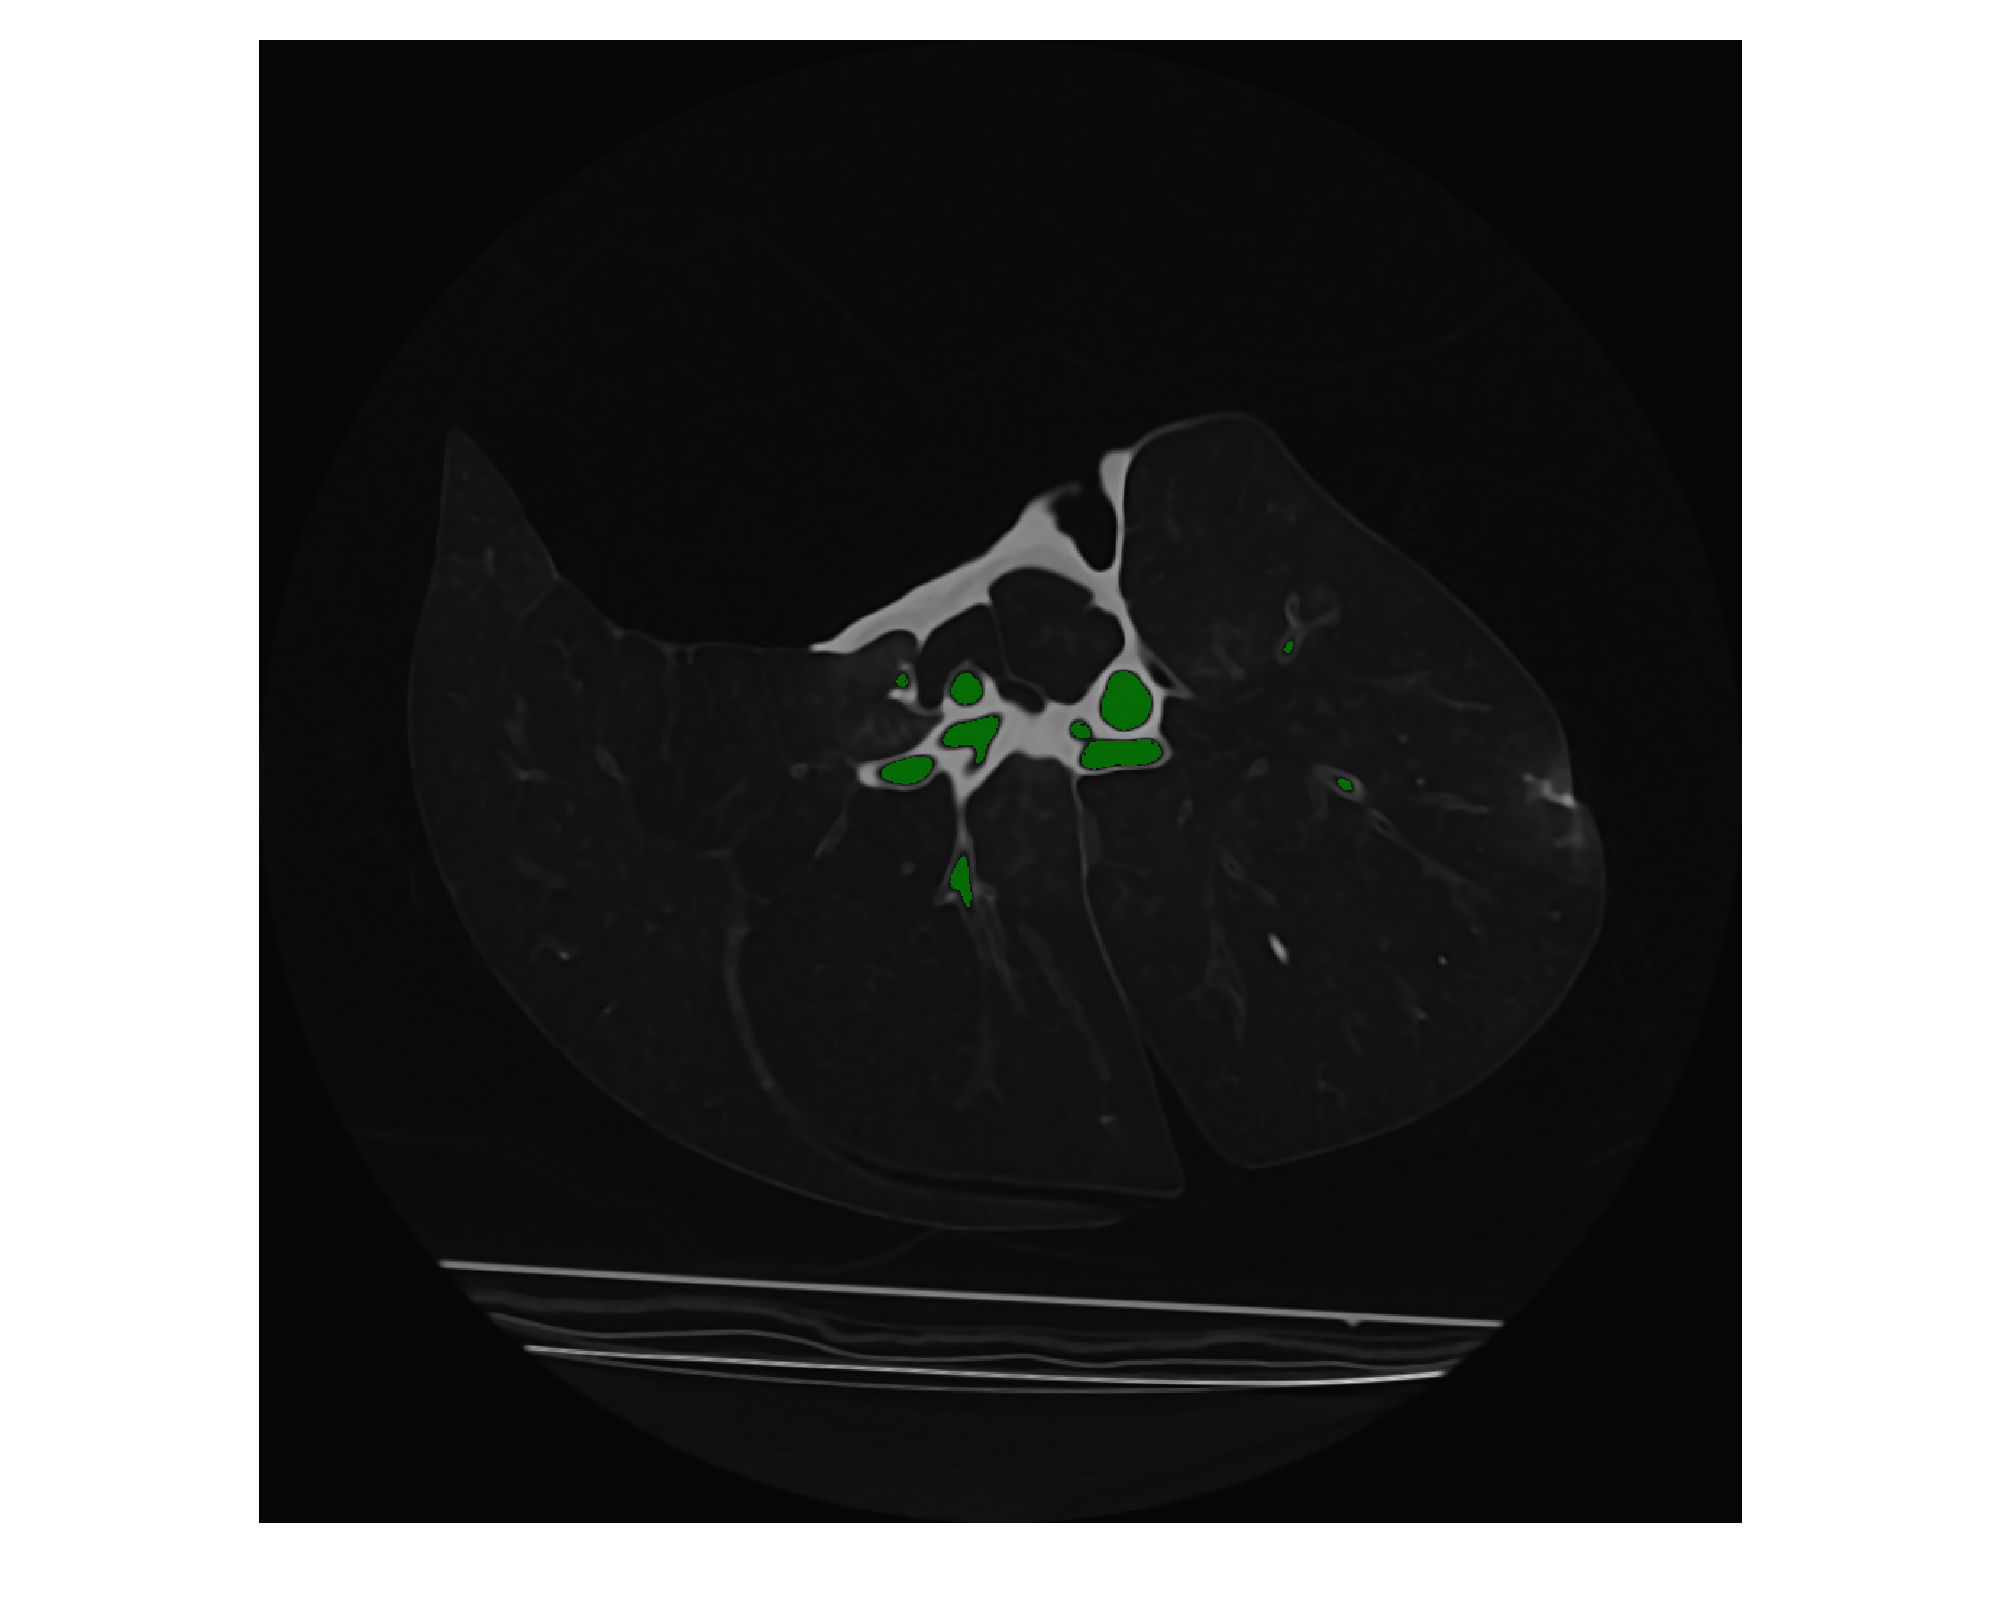

In [38]:
img_int = sitk.Cast(sitk.RescaleIntensity(rlung122_smooth), seg_122.GetPixelID())
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_int, seg_122)])

In 205 there's a slice where the airway opens into the surrounding space which really screws up the segmentation:

<IPython.core.display.Javascript object>


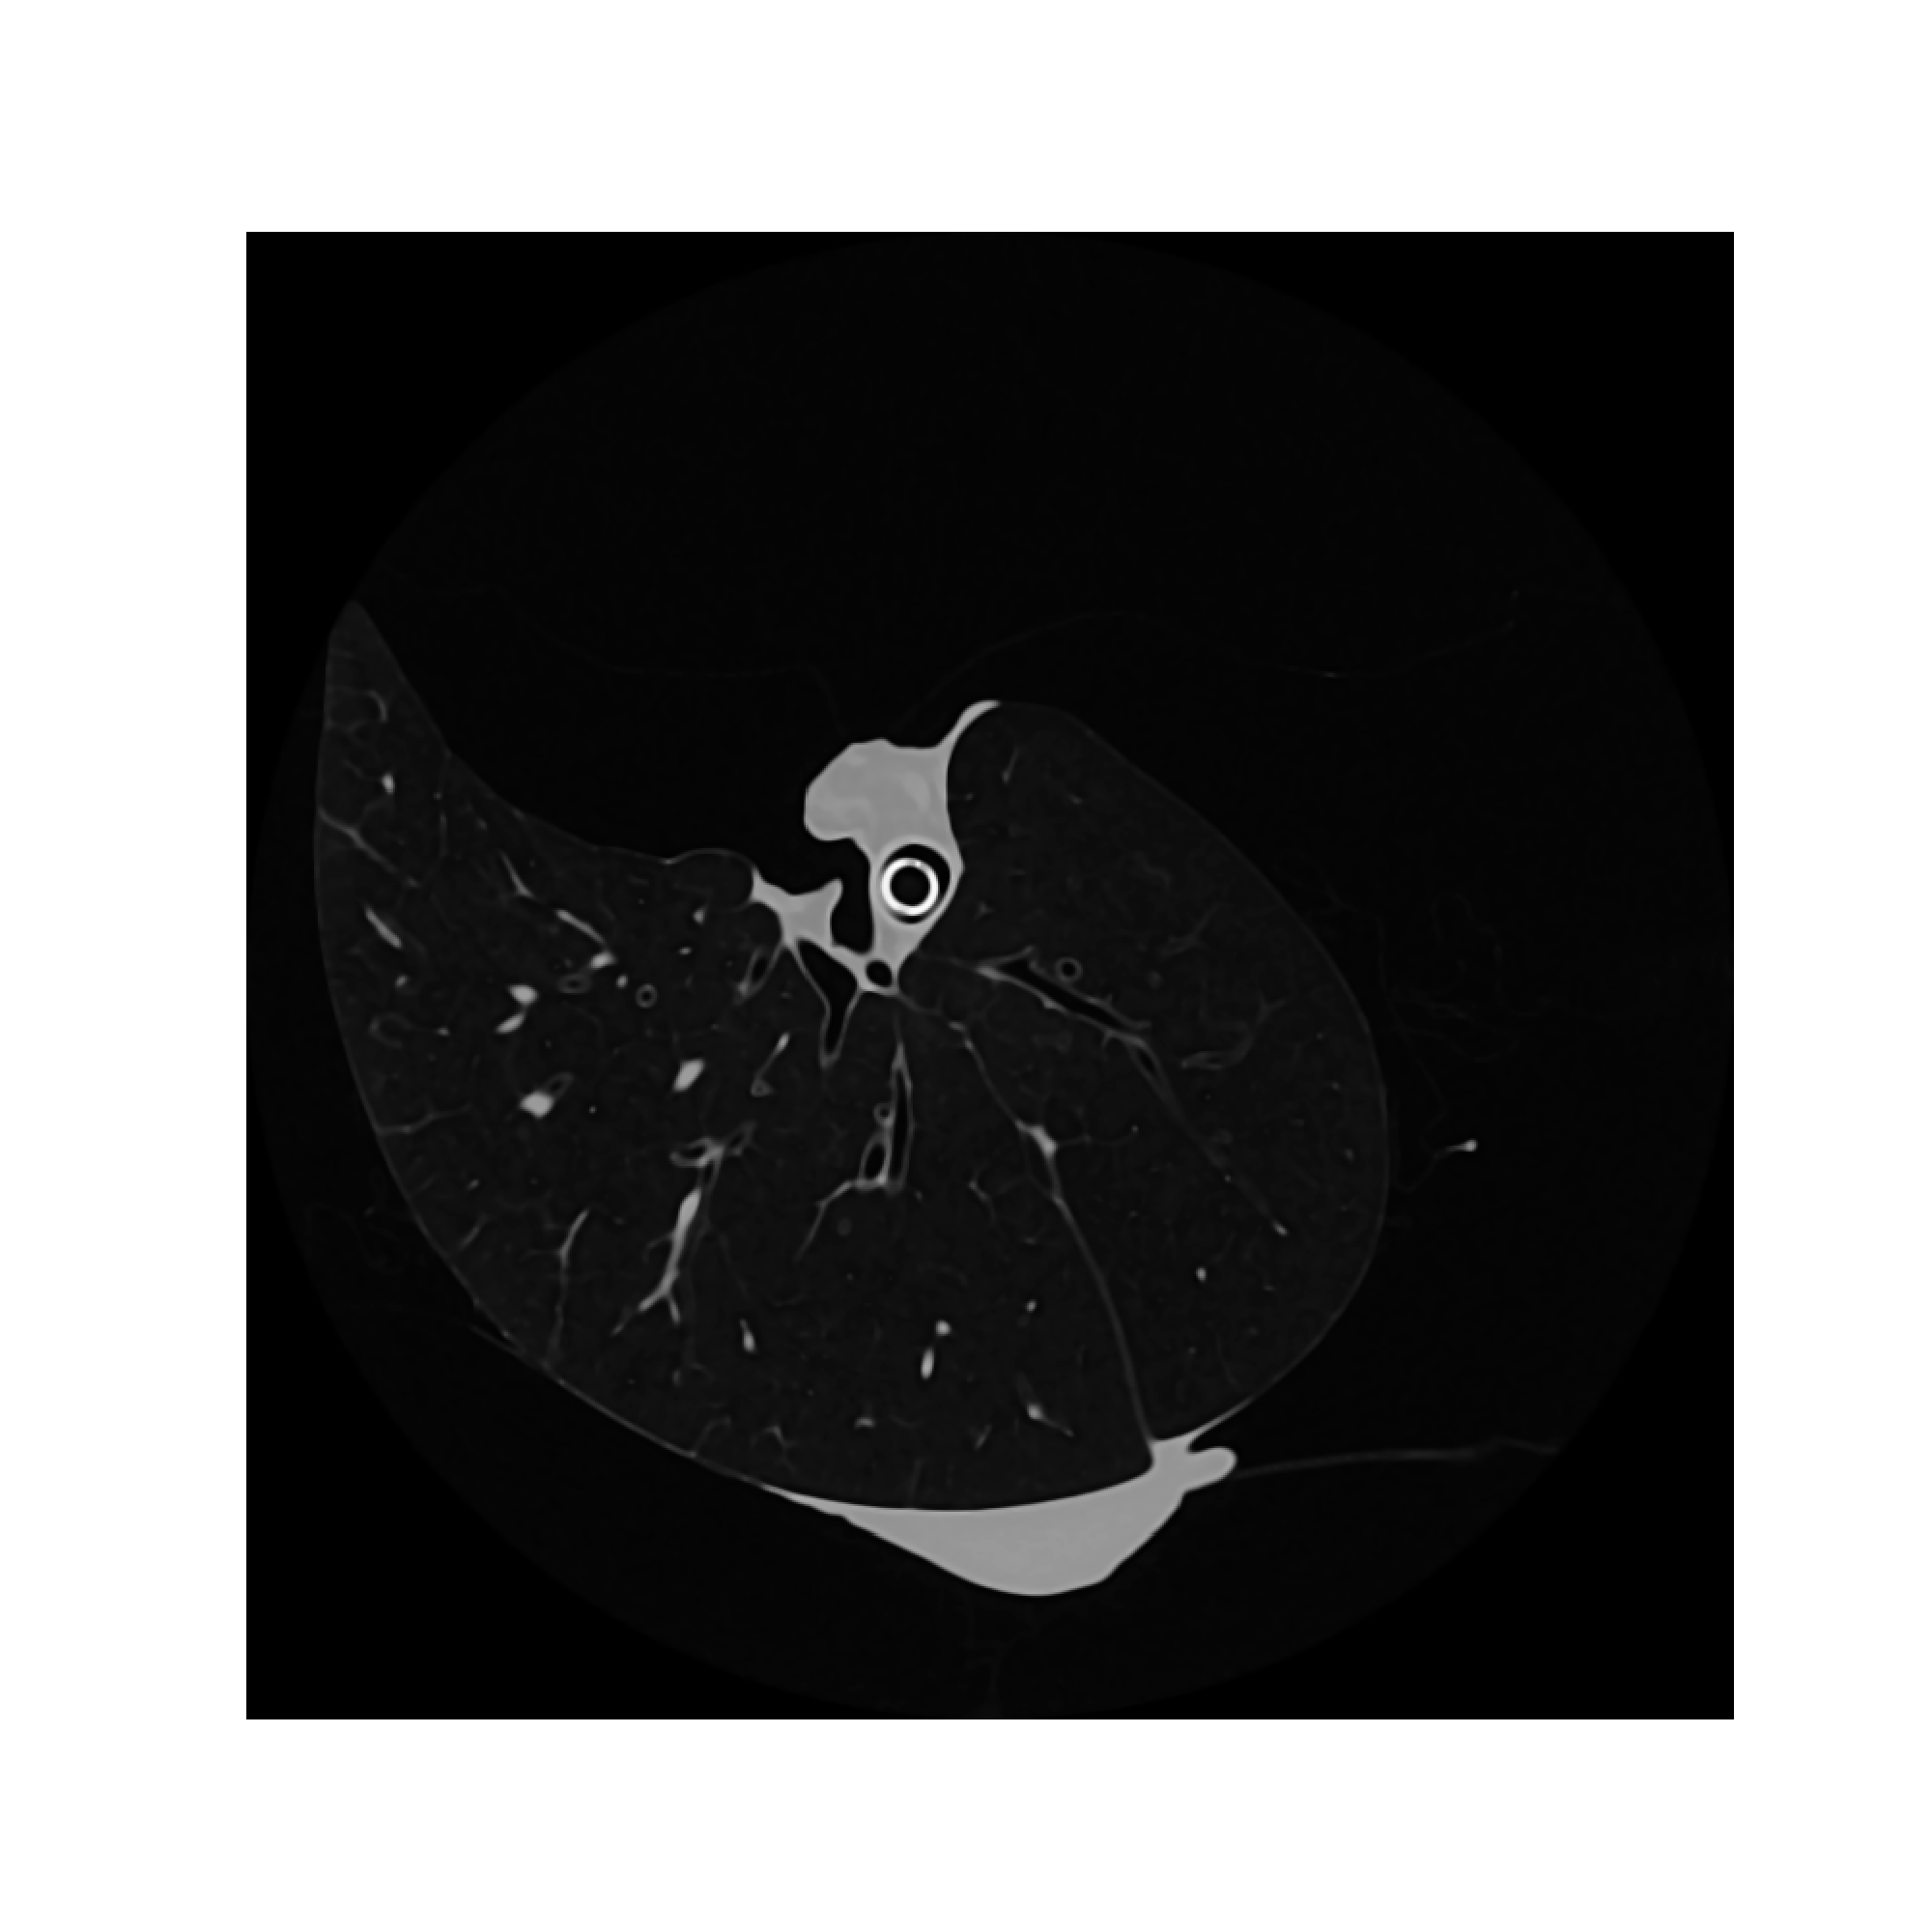

<IPython.core.display.Javascript object>


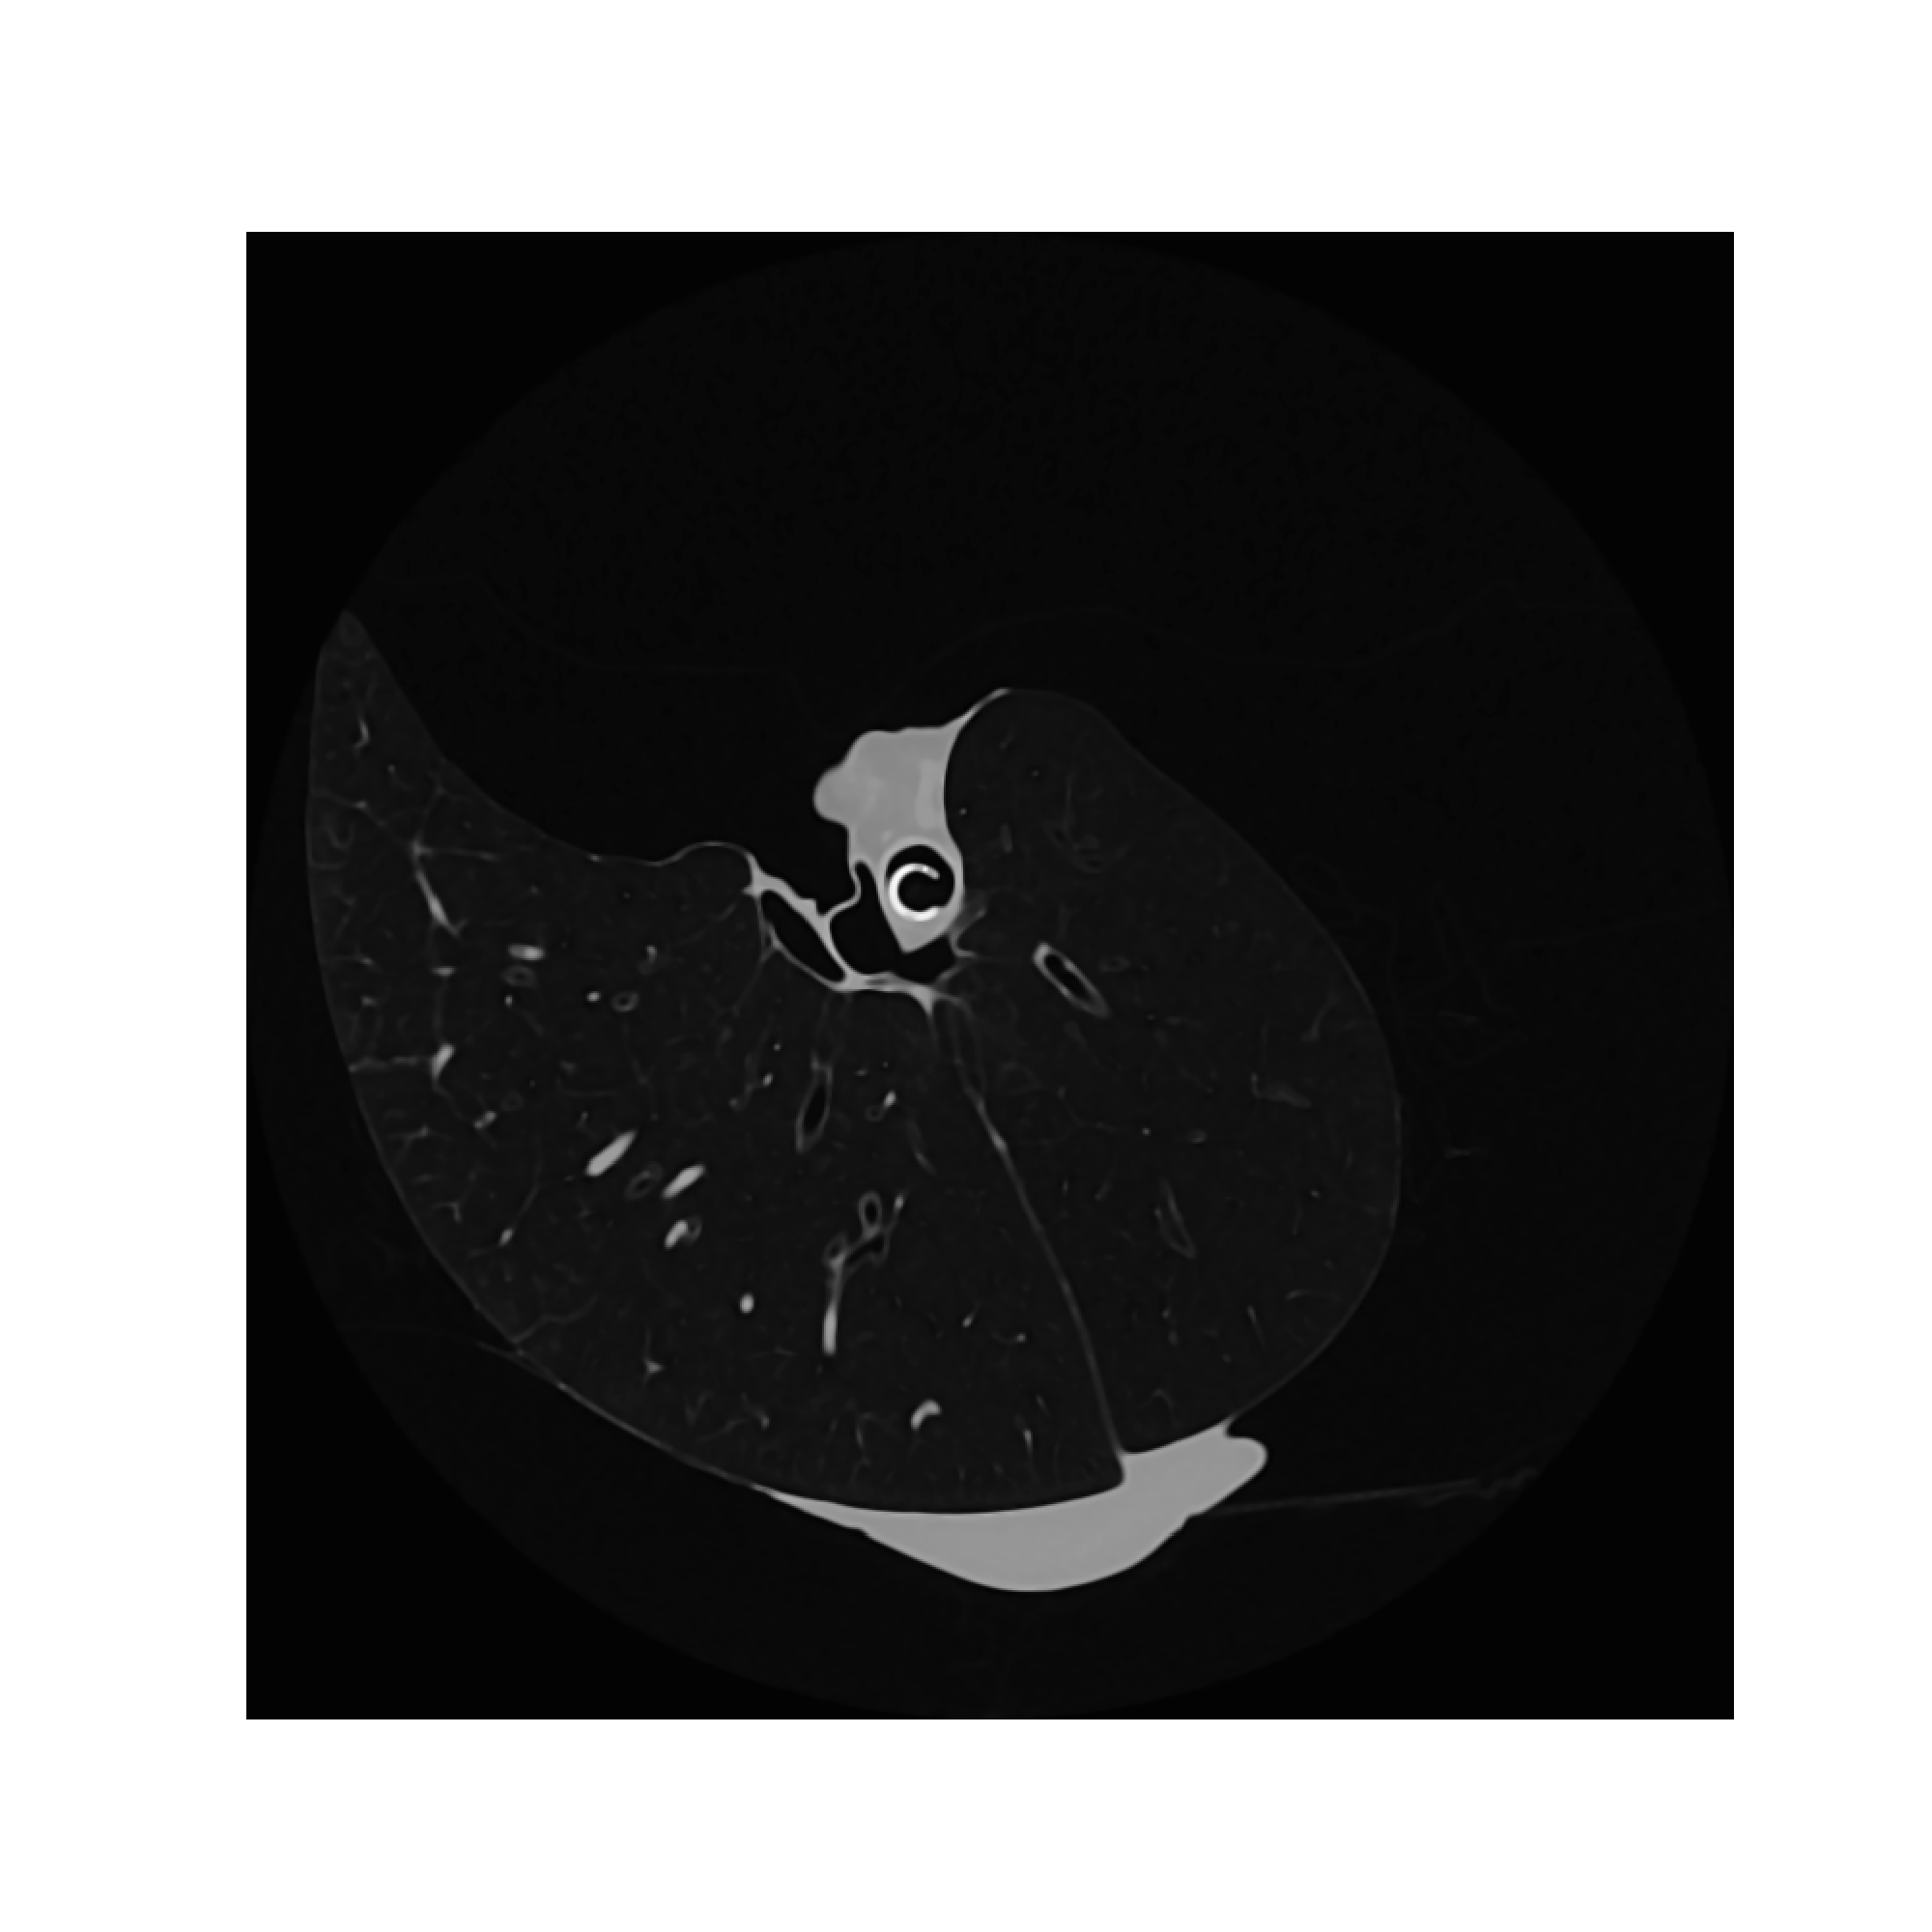

In [90]:
plot_img(rlung205_smooth, 517)
plot_img(rlung205_smooth, 500)

## Save segmentations

In [49]:
sitk.WriteImage(seg_122, "../data/r122_airway.mha")

## Plot segmentation as a mesh

In [118]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize

def make_mesh(image, threshold=-300, step_size=1):
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, None, step_size=step_size, allow_degenerate=True) 
    return verts, faces


v, f = make_mesh(sitk.GetArrayViewFromImage(seg_122), 0)

import ipyvolume as ipv
x,y,z = zip(*v)

In [120]:
ipv.figure()
mesh = ipv.plot_trisurf(x, y, z, triangles=f, color='orange')
ipv.show()